## Length, Recency, Frequency, Monetary Analysis

This notebook was created by using a dataset provided to me from the Canadian Brewhouse as part of my capstone project with the Data Analytics Program at NAIT. It contained data on customer check ins to the Brewhouse's loyalty app program.

The goal of this analysis was to create segments of the customers based on how active they are while using the loyalty app and visiting the Canadian Brewhouse. They were grouped based on the value of four factors: the time between the first and most recent check in, how recently they checked in at a location, how many times they have checked in overall, how much money they have spent in total, and the time from the first and most recent check in. Each of these values were calculated from this check in data, then converted into a score and all users were grouped into 5 segments based on that score. By creating these segments we can then determine the quality and proportions of the customer base overall and correlate that with locations and number of loyalty points. 

Since this dataset contains an entry for each visit, grouping and combining of users and values was necessary to get accurate results for the total vists of each customer, since the values of frequency, monetary and length would be cumulative.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('checkin_cleaned.csv')
df

,Checkin ID,User ID,Store Number,Points earned,Receipt amount,Status,Channel,Checkin scan time,Location name,Earnable amount
0,105775285,60374143,2,262,17.47,loyalty,Mobile,"June 21, 2018 12:29 PM MST",Edmonton South,17.469999
1,107249778,60374143,2,285,18.98,loyalty,Mobile,"June 28, 2018 01:28 PM MST",Edmonton South,18.980000
2,113291909,60374143,2,374,24.96,loyalty,Mobile,"July 24, 2018 01:23 PM MST",Edmonton South,24.959999
3,115259488,60374143,2,"1,147",76.45,loyalty,Mobile,"August 01, 2018 06:51 PM MST",Edmonton South,76.449997
4,118407244,60374143,2,225,14.98,loyalty,Mobile,"August 16, 2018 12:35 PM MST",Edmonton South,14.980000
...,...,...,...,...,...,...,...,...,...,...
1048569,764758921,238628034,16,689,45.96,loyalty,Mobile,"September 10, 2022 10:45 PM MST",Regina Grasslands,45.959999
1048570,764758931,250344360,0,75,0,gift,Mobile,"September 10, 2022 10:45 PM MST",The Canadian Brewhouse HQ,0.000000
1048571,764758951,87615909,31,"1,559",103.91,loyalty,Mobile,"September 10, 2022 10:45 PM MST",Lewis Estates,103.910004
1048572,764758955,128997717,11,"1,649",109.91,loyalty,Mobile,"September 10, 2022 10:45 PM MST",Leduc,109.910004


In [3]:
df.drop(columns=['Channel', 'Status'], inplace=True)
df

,Checkin ID,User ID,Store Number,Points earned,Receipt amount,Checkin scan time,Location name,Earnable amount
0,105775285,60374143,2,262,17.47,"June 21, 2018 12:29 PM MST",Edmonton South,17.469999
1,107249778,60374143,2,285,18.98,"June 28, 2018 01:28 PM MST",Edmonton South,18.980000
2,113291909,60374143,2,374,24.96,"July 24, 2018 01:23 PM MST",Edmonton South,24.959999
3,115259488,60374143,2,"1,147",76.45,"August 01, 2018 06:51 PM MST",Edmonton South,76.449997
4,118407244,60374143,2,225,14.98,"August 16, 2018 12:35 PM MST",Edmonton South,14.980000
...,...,...,...,...,...,...,...,...
1048569,764758921,238628034,16,689,45.96,"September 10, 2022 10:45 PM MST",Regina Grasslands,45.959999
1048570,764758931,250344360,0,75,0,"September 10, 2022 10:45 PM MST",The Canadian Brewhouse HQ,0.000000
1048571,764758951,87615909,31,"1,559",103.91,"September 10, 2022 10:45 PM MST",Lewis Estates,103.910004
1048572,764758955,128997717,11,"1,649",109.91,"September 10, 2022 10:45 PM MST",Leduc,109.910004


In [4]:
# Clean up some of the data
df['Checkin scan time'] = df['Checkin scan time'].str.replace('MST', '')
df['Receipt amount'] = df['Receipt amount'].str.replace(',','')
df['Receipt amount'] = df['Receipt amount'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 0 to 1048573
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Checkin ID         1048574 non-null  int64  
 1   User ID            1048574 non-null  int64  
 2   Store Number       1048574 non-null  int64  
 3   Points earned      1048574 non-null  object 
 4   Receipt amount     1048574 non-null  float64
 5   Checkin scan time  1048574 non-null  object 
 6   Location name      1048574 non-null  object 
 7   Earnable amount    1048574 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 64.0+ MB


In [5]:
# Convert check in to datetime format
df['Checkin scan time'] = pd.to_datetime(df['Checkin scan time'])

The check in dataset only has information up to September 10, 2022, so for the purposes of a comparison date while doing this analysis we acted as thought the current date was one day after this date, September 11, 2022. Otherwise there would be a very large gap for even the most recent vists if we had used the current date.

### Recency
Recency was calculated by comparing the date of check in with the 'current date' to determine the last time a customer has visited a Brewhouse location, measured in number of days. To create a recency score these values were converted into a scale of 1-5, and the user were grouped into them. In this case, a score of 1 indicated a long time since the last visit, while a 5 indicated a short time.

In [6]:
# Set current date to day after end of dataset: 2022/09/11
current_date = pd.to_datetime('2022-09-11')

#Calculate Recency
df['Recency'] = (current_date - df['Checkin scan time']).dt.days

# Assign Recency Score
df['Recency Score'] = pd.qcut(df['Recency'], q=5, labels=range(5,0, -1))
df

,Checkin ID,User ID,Store Number,Points earned,Receipt amount,Checkin scan time,Location name,Earnable amount,Recency,Recency Score
0,105775285,60374143,2,262,17.47,2018-06-21 12:29:00,Edmonton South,17.469999,1542,1
1,107249778,60374143,2,285,18.98,2018-06-28 13:28:00,Edmonton South,18.980000,1535,1
2,113291909,60374143,2,374,24.96,2018-07-24 13:23:00,Edmonton South,24.959999,1509,1
3,115259488,60374143,2,"1,147",76.45,2018-08-01 18:51:00,Edmonton South,76.449997,1501,1
4,118407244,60374143,2,225,14.98,2018-08-16 12:35:00,Edmonton South,14.980000,1486,1
...,...,...,...,...,...,...,...,...,...,...
1048569,764758921,238628034,16,689,45.96,2022-09-10 22:45:00,Regina Grasslands,45.959999,0,5
1048570,764758931,250344360,0,75,0.00,2022-09-10 22:45:00,The Canadian Brewhouse HQ,0.000000,0,5
1048571,764758951,87615909,31,"1,559",103.91,2022-09-10 22:45:00,Lewis Estates,103.910004,0,5
1048572,764758955,128997717,11,"1,649",109.91,2022-09-10 22:45:00,Leduc,109.910004,0,5


### Frequency
Frequency was a measure of how many times in total each customer had visited the Canadian Brewhouse. This value was calculated by first grouping by User ID to easily determine the number of visits for each customer, then creating a column of that count. From there the dataset was merged back and the frequency score was created with groups of labels 1 to 5. In this case a 1 indicated a customer who visited less often and a 5 indicated a customer who visited very often.

In [7]:
# Create Frequency
frequency = df.groupby('User ID').size().reset_index(name='Frequency')

df = pd.merge(df, frequency, on='User ID', how='left')

In [8]:
# Assign frequency scores
df['Frequency Score'] = pd.qcut(df['Frequency'], q=5, labels=range(1,6))
df

,Checkin ID,User ID,Store Number,Points earned,Receipt amount,Checkin scan time,Location name,Earnable amount,Recency,Recency Score,Frequency,Frequency Score
0,105775285,60374143,2,262,17.47,2018-06-21 12:29:00,Edmonton South,17.469999,1542,1,398,5
1,107249778,60374143,2,285,18.98,2018-06-28 13:28:00,Edmonton South,18.980000,1535,1,398,5
2,113291909,60374143,2,374,24.96,2018-07-24 13:23:00,Edmonton South,24.959999,1509,1,398,5
3,115259488,60374143,2,"1,147",76.45,2018-08-01 18:51:00,Edmonton South,76.449997,1501,1,398,5
4,118407244,60374143,2,225,14.98,2018-08-16 12:35:00,Edmonton South,14.980000,1486,1,398,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,764758921,238628034,16,689,45.96,2022-09-10 22:45:00,Regina Grasslands,45.959999,0,5,13,2
1048570,764758931,250344360,0,75,0.00,2022-09-10 22:45:00,The Canadian Brewhouse HQ,0.000000,0,5,1,1
1048571,764758951,87615909,31,"1,559",103.91,2022-09-10 22:45:00,Lewis Estates,103.910004,0,5,27,3
1048572,764758955,128997717,11,"1,649",109.91,2022-09-10 22:45:00,Leduc,109.910004,0,5,28,3


### Monetary
Monetary values were a measure of how much money each customer spent in total across all of their visits, according to the receipt data. Once again the dataset was grouped by User ID, then the monetary value was created by taking the sum of the receipt amounts. The data was merged back and these monetary values were assigned into the same 5 groups based on their value. In this case a 1 indicates a customer who did not spent much money, while a 5 indicates a customer who spent a large amount of money.

In [9]:
# Create Monetary 
monetary = df.groupby('User ID')['Receipt amount'].sum().reset_index()
monetary.rename(columns={'Receipt amount': 'Monetary'}, inplace=True)

df = pd.merge(df, monetary, on='User ID', how='left')

In [10]:
# Assign Monetary Score
df['Monetary Score'] = pd.qcut(df['Monetary'], q=5, labels=range(1, 6))
df

,Checkin ID,User ID,Store Number,Points earned,Receipt amount,Checkin scan time,Location name,Earnable amount,Recency,Recency Score,Frequency,Frequency Score,Monetary,Monetary Score
0,105775285,60374143,2,262,17.47,2018-06-21 12:29:00,Edmonton South,17.469999,1542,1,398,5,15929.14,5
1,107249778,60374143,2,285,18.98,2018-06-28 13:28:00,Edmonton South,18.980000,1535,1,398,5,15929.14,5
2,113291909,60374143,2,374,24.96,2018-07-24 13:23:00,Edmonton South,24.959999,1509,1,398,5,15929.14,5
3,115259488,60374143,2,"1,147",76.45,2018-08-01 18:51:00,Edmonton South,76.449997,1501,1,398,5,15929.14,5
4,118407244,60374143,2,225,14.98,2018-08-16 12:35:00,Edmonton South,14.980000,1486,1,398,5,15929.14,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,764758921,238628034,16,689,45.96,2022-09-10 22:45:00,Regina Grasslands,45.959999,0,5,13,2,661.70,3
1048570,764758931,250344360,0,75,0.00,2022-09-10 22:45:00,The Canadian Brewhouse HQ,0.000000,0,5,1,1,0.00,1
1048571,764758951,87615909,31,"1,559",103.91,2022-09-10 22:45:00,Lewis Estates,103.910004,0,5,27,3,1856.56,4
1048572,764758955,128997717,11,"1,649",109.91,2022-09-10 22:45:00,Leduc,109.910004,0,5,28,3,1802.53,4


### Length
Length values were a measure of the time from the first and last visit, to see if any customers would return to the Brewhouse. They were calculated by grouping the customers by User ID and comparing the maximum and minimum check in time. The amount of days between these values was the length value, which was again assigned to groups with labels of 1 to 5. In this case a 1 indicates a customer who visited possibly only once or very few times, while a 5 indicated a customer who visited multiple times.

In [11]:
# Find the first and last visit
first_visit = df.groupby('User ID')['Checkin scan time'].min().reset_index()
last_visit = df.groupby('User ID')['Checkin scan time'].max().reset_index()

# Calculate the length (number of days between first and last visit) for each customer
length = pd.merge(first_visit, last_visit, on='User ID', suffixes=('_first', '_last'))

In [12]:
# Calculate Length
length['Length'] = (length['Checkin scan time_last'] - length['Checkin scan time_first']).dt.days

# Merge length back to the original dataset
df = pd.merge(df, length[['User ID', 'Length']], on='User ID', how='left')

df

,Checkin ID,User ID,Store Number,Points earned,Receipt amount,Checkin scan time,Location name,Earnable amount,Recency,Recency Score,Frequency,Frequency Score,Monetary,Monetary Score,Length
0,105775285,60374143,2,262,17.47,2018-06-21 12:29:00,Edmonton South,17.469999,1542,1,398,5,15929.14,5,1517
1,107249778,60374143,2,285,18.98,2018-06-28 13:28:00,Edmonton South,18.980000,1535,1,398,5,15929.14,5,1517
2,113291909,60374143,2,374,24.96,2018-07-24 13:23:00,Edmonton South,24.959999,1509,1,398,5,15929.14,5,1517
3,115259488,60374143,2,"1,147",76.45,2018-08-01 18:51:00,Edmonton South,76.449997,1501,1,398,5,15929.14,5,1517
4,118407244,60374143,2,225,14.98,2018-08-16 12:35:00,Edmonton South,14.980000,1486,1,398,5,15929.14,5,1517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,764758921,238628034,16,689,45.96,2022-09-10 22:45:00,Regina Grasslands,45.959999,0,5,13,2,661.70,3,66
1048570,764758931,250344360,0,75,0.00,2022-09-10 22:45:00,The Canadian Brewhouse HQ,0.000000,0,5,1,1,0.00,1,0
1048571,764758951,87615909,31,"1,559",103.91,2022-09-10 22:45:00,Lewis Estates,103.910004,0,5,27,3,1856.56,4,1224
1048572,764758955,128997717,11,"1,649",109.91,2022-09-10 22:45:00,Leduc,109.910004,0,5,28,3,1802.53,4,675


In [13]:
# Assign Length Score
df['Length Score'] = pd.qcut(df['Length'], q=5, labels=range(1, 6))
df

,Checkin ID,User ID,Store Number,Points earned,Receipt amount,Checkin scan time,Location name,Earnable amount,Recency,Recency Score,Frequency,Frequency Score,Monetary,Monetary Score,Length,Length Score
0,105775285,60374143,2,262,17.47,2018-06-21 12:29:00,Edmonton South,17.469999,1542,1,398,5,15929.14,5,1517,5
1,107249778,60374143,2,285,18.98,2018-06-28 13:28:00,Edmonton South,18.980000,1535,1,398,5,15929.14,5,1517,5
2,113291909,60374143,2,374,24.96,2018-07-24 13:23:00,Edmonton South,24.959999,1509,1,398,5,15929.14,5,1517,5
3,115259488,60374143,2,"1,147",76.45,2018-08-01 18:51:00,Edmonton South,76.449997,1501,1,398,5,15929.14,5,1517,5
4,118407244,60374143,2,225,14.98,2018-08-16 12:35:00,Edmonton South,14.980000,1486,1,398,5,15929.14,5,1517,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,764758921,238628034,16,689,45.96,2022-09-10 22:45:00,Regina Grasslands,45.959999,0,5,13,2,661.70,3,66,1
1048570,764758931,250344360,0,75,0.00,2022-09-10 22:45:00,The Canadian Brewhouse HQ,0.000000,0,5,1,1,0.00,1,0,1
1048571,764758951,87615909,31,"1,559",103.91,2022-09-10 22:45:00,Lewis Estates,103.910004,0,5,27,3,1856.56,4,1224,4
1048572,764758955,128997717,11,"1,649",109.91,2022-09-10 22:45:00,Leduc,109.910004,0,5,28,3,1802.53,4,675,3


### LRFM Score
With the creation of the four scores we can now do some additional analysis on the customers. The first step is to create a combined score known as the LRFM Score, calculated as both the average and sum of the other scores.  

In [20]:
df[['Length Score', 'Recency Score', 'Frequency Score', 'Monetary Score']] = df[['Length Score', 'Recency Score', 'Frequency Score', 'Monetary Score']].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048574 entries, 0 to 1048573
Data columns (total 18 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Checkin ID         1048574 non-null  int64         
 1   User ID            1048574 non-null  int64         
 2   Store Number       1048574 non-null  int64         
 3   Points earned      1048574 non-null  object        
 4   Receipt amount     1048574 non-null  float64       
 5   Status             1048574 non-null  object        
 6   Channel            1048574 non-null  object        
 7   Checkin scan time  1048574 non-null  datetime64[ns]
 8   Location name      1048574 non-null  object        
 9   Earnable amount    1048574 non-null  float64       
 10  Recency            1048574 non-null  int64         
 11  Recency Score      1048574 non-null  int32         
 12  Frequency          1048574 non-null  int64         
 13  Frequency Score    1048574 

In [21]:
# Combine scores together to make an average of the four scores: LRFM Score
df['LRFM Score'] = ((df['Length Score'] + df['Recency Score'] +
                          df['Frequency Score'] + df['Monetary Score']) / 4).round()

In [22]:
# Scale the LRFM Score
min_score = df['LRFM Score'].min()
max_score = df['LRFM Score'].max()
df['LRFM Score'] = ((df['LRFM Score'] - min_score) / (max_score - min_score) * 4) + 1

In [23]:
df['LRFM Score'] = df['LRFM Score'].round().astype(int)
df['LRFM Score (Average Score)'] = df['LRFM Score']
df.drop(columns=['LRFM Score'], inplace=True)

In [24]:
# Combine the score values to create a sum version of LRFM Score
df['LRFM Score (Sum)'] = df['Length Score'].astype(int) + df['Monetary Score'].astype(int) + df['Recency Score'].astype(int) + df['Frequency Score'].astype(int)

### Customer Loyalty Level
With the newly created LRFM score we can also use it to classify the customers again by creating a new custom set of groupings based on their sum LRFM Score. This would be a more general labeling of how they are as customers, since larger scores in all the categories would indicate that they were a valuable customer who visited the Brewhouse often and spent more money.

We chose to set the loyalty levels to Poor (4-5), Low (6-9), Medium (10-15), and High (16-20). 

In [25]:
# Create a Customer Loyalty Level 
bins = [0, 6, 10, 16, 21]
labels = ['Poor', 'Low', 'Medium', 'High']

df['Customer Loyalty Level'] = pd.cut(df['LRFM Score (Sum)'], bins=bins, labels=labels, right=False)
df

,Checkin ID,User ID,Store Number,Points earned,Receipt amount,Status,Channel,Checkin scan time,Location name,Earnable amount,...,Recency Score,Frequency,Frequency Score,Monetary,Monetary Score,Length,Length Score,LRFM Score (Average Score),LRFM Score (Sum),Customer Loyalty Level
0,105775285,60374143,2,262,17.47,loyalty,Mobile,2018-06-21 12:29:00,Edmonton South,17.469999,...,1,398,5,15929.14,5,1517,5,4,16,High
1,107249778,60374143,2,285,18.98,loyalty,Mobile,2018-06-28 13:28:00,Edmonton South,18.980000,...,1,398,5,15929.14,5,1517,5,4,16,High
2,113291909,60374143,2,374,24.96,loyalty,Mobile,2018-07-24 13:23:00,Edmonton South,24.959999,...,1,398,5,15929.14,5,1517,5,4,16,High
3,115259488,60374143,2,"1,147",76.45,loyalty,Mobile,2018-08-01 18:51:00,Edmonton South,76.449997,...,1,398,5,15929.14,5,1517,5,4,16,High
4,118407244,60374143,2,225,14.98,loyalty,Mobile,2018-08-16 12:35:00,Edmonton South,14.980000,...,1,398,5,15929.14,5,1517,5,4,16,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,764758921,238628034,16,689,45.96,loyalty,Mobile,2022-09-10 22:45:00,Regina Grasslands,45.959999,...,5,13,2,661.70,3,66,1,3,11,Medium
1048570,764758931,250344360,0,75,0.00,gift,Mobile,2022-09-10 22:45:00,The Canadian Brewhouse HQ,0.000000,...,5,1,1,0.00,1,0,1,2,8,Low
1048571,764758951,87615909,31,"1,559",103.91,loyalty,Mobile,2022-09-10 22:45:00,Lewis Estates,103.910004,...,5,27,3,1856.56,4,1224,4,4,16,High
1048572,764758955,128997717,11,"1,649",109.91,loyalty,Mobile,2022-09-10 22:45:00,Leduc,109.910004,...,5,28,3,1802.53,4,675,3,4,15,Medium


To account for any customers who had recently joined the app and may have not had the chance to demonstrate their value as customers, we created a new loyalty level called 'New' for those who had one visit within the last month of the dataset, regardless of their scores.

In [26]:
# Creating a 'New' category to take into account the customers who are recent users of the app
df['Customer Loyalty Level'] = df['Customer Loyalty Level'].cat.add_categories('New')

df.loc[(df['Frequency'] == 1) & (df['Recency'] <= 31), 'Customer Loyalty Level'] = 'New'

The 'Canadian Brewhouse HQ' location seems to only be related to the redemption of free loyalty points, so it was removed to provide more accurate location information. 

In [27]:
new_df = df[df['Location name'] != 'The Canadian Brewhouse HQ']

Finally, I created a new data frame of only the LRFM information to be used for visualizations and further analysis.

In [28]:
userID = new_df.groupby('User ID')

df_userID = pd.DataFrame(userID[['Recency','Recency Score', 'Frequency','Frequency Score','Monetary','Monetary Score','Length',
                                 'Length Score', 'LRFM Score (Average Score)', 'LRFM Score (Sum)', 
                                 'Customer Loyalty Level', 'Location name']].max())
df_userID

,Recency,Recency Score,Frequency,Frequency Score,Monetary,Monetary Score,Length,Length Score,LRFM Score (Average Score),LRFM Score (Sum),Customer Loyalty Level,Location name
User ID,,,,,,,,,,,,
59573503,1311,5,11,2,14.72,1,1272,4,3,12,Medium,Winnipeg
59576846,1333,2,10,2,258.29,2,505,2,2,8,Low,Windermere
59581103,985,4,23,3,555.66,2,658,3,3,12,Medium,Windermere
59581126,1361,5,89,5,2288.84,4,1357,5,5,19,High,Regina Grasslands
59581173,1099,3,9,2,746.60,3,564,3,3,11,Medium,St. Albert: South
...,...,...,...,...,...,...,...,...,...,...,...,...
250340749,0,5,1,1,34.97,1,0,1,2,8,New,Moose Jaw
250340823,0,5,2,1,36.97,1,0,1,2,8,Low,Fort McMurray
250340932,0,5,1,1,22.98,1,0,1,2,8,New,Moose Jaw


## Linear Regression/Correlation Analysis
Now that we have created these scores it's important to understand the relationship they have with each other and how they affect overall customer performance. Additionally, if it were possible to predict other values based on each other they could be used with active data to understand what a customer might do. In this case we chose to look at the correlation factor between all the variables, but more specifically those that had a strong postive relationship.

In [5]:
df_userID = pd.read_csv('UserID_LRFM.csv')
df_userID.corr()
#corr[corr >0.75]

,User ID,Recency,Recency Score,Frequency,Frequency Score,Monetary,Monetary Score,Length,Length Score,LRFM Score (Average Score),LRFM Score (Sum)
User ID,1.000000,-0.900297,0.508772,-0.200506,-0.319532,-0.195398,-0.303117,-0.482391,-0.474775,-0.094340,-0.106507
Recency,-0.900297,1.000000,-0.555506,0.231929,0.358240,0.224554,0.334750,0.492510,0.484578,0.086659,0.108666
Recency Score,0.508772,-0.555506,1.000000,0.199393,0.334650,0.202744,0.339282,0.388631,0.372397,0.677279,0.704323
Frequency,-0.200506,0.231929,0.199393,1.000000,0.681559,0.886537,0.626035,0.446781,0.446720,0.535123,0.563805
Frequency Score,-0.319532,0.358240,0.334650,0.681559,1.000000,0.654523,0.872756,0.717519,0.713740,0.810830,0.851431
Monetary,-0.195398,0.224554,0.202744,0.886537,0.654523,1.000000,0.660073,0.440753,0.440734,0.536677,0.565282
Monetary Score,-0.303117,0.334750,0.339282,0.626035,0.872756,0.660073,1.000000,0.694511,0.695173,0.792820,0.848318
Length,-0.482391,0.492510,0.388631,0.446781,0.717519,0.440753,0.694511,1.000000,0.972901,0.790482,0.839418
Length Score,-0.474775,0.484578,0.372397,0.446720,0.713740,0.440734,0.695173,0.972901,1.000000,0.788400,0.840795
LRFM Score (Average Score),-0.094340,0.086659,0.677279,0.535123,0.810830,0.536677,0.792820,0.790482,0.788400,1.000000,0.947054


As we can see, Frequency and Monetary have a strong relationship (0.87) and in the case of The Canadian Brewhouse this would be beneficial for them to understand how knowing how often someone visits would correlate to how much money they spend.

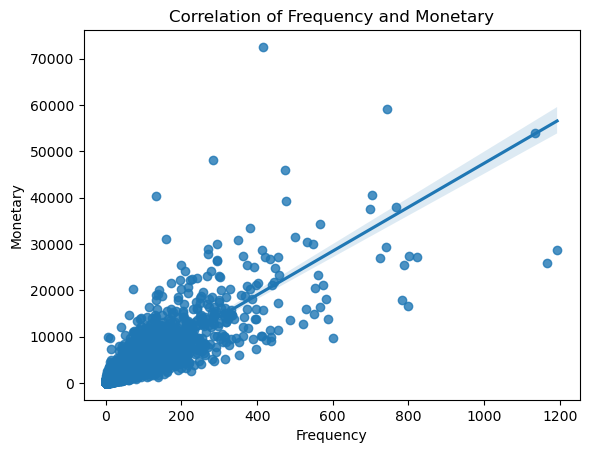

In [32]:
sns.regplot(data=df_userID, x='Frequency', y='Monetary')
plt.title('Correlation of Frequency and Monetary')
plt.show()

Using linear regression we can create a function to predict how much money a customer would spend based on how many visits they had. By fitting the data we can see that the R2 value is 0.78595 which also indicates that the model would predict fairly accurately.

In [6]:
frequency = df_userID[['Frequency']]
monetary = df_userID['Monetary']

lr = LinearRegression()
model = lr.fit(frequency, monetary)
R2 = round(model.score(frequency, monetary), 5)
print('The R2 value for the correlation of frequency and monetary is: ' + str(R2))

The R2 value for the correlation of frequency and monetary is: 0.78595


In [7]:
def predict_monetary(variable):
    value = round(model.predict([[variable]])[0], 3)
    return f"The expected monetary value for this customer would be: ${value}"

In [8]:
predict_monetary(30)

'The expected monetary value for this customer would be: $1442.103'

Using this model we can conclude that, for example, if a customer visited The Canadian Brewhouse 30 times, they would have spent approximately $1442.10. 

Each visit would increase a customers spending by approximately $47.37.

The uses of this linear regression model would mostly relate to looking at customer frequency data from an active customer base and then determining which groups are in need of a potential push. This is where marketing and promotional campaigns could come in to play as a way to incentivize customers who may be on the edge of the next monetary or customer loyalty level to come to the Brewhouse. 